In [13]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt

In [14]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

In [15]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="dolphin3:latest", 
    temperature=0
)

In [16]:
def chatbot_node(state: State):
    ai_msg = llm.invoke(state["messages"])
    return {"messages": [ai_msg]}
graph_builder.add_node("chatbot", chatbot_node)

# Human review node (HITL checkpoint)

In [17]:
def human_review_node(state: State):
    # Pause execution and wait for human confirmation
    last_msg = state["messages"][-1].content
    print("\n[Draft from AI]:", last_msg)
    user_decision = input("[HITL] Approve this? (yes/edit/no): ").strip().lower()

    if user_decision == "yes":
        return state
    elif user_decision == "edit":
        edited = input("Enter your corrected response: ")
        return {"messages": [{"role": "assistant", "content": edited}]}
    else:
        # Interrupt flow until resumed manually
        return interrupt("AI response rejected. Provide alternate text.")
    
graph_builder.add_node("human_review", human_review_node)

In [18]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", "human_review")
graph_builder.add_edge("human_review", END)

In [19]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

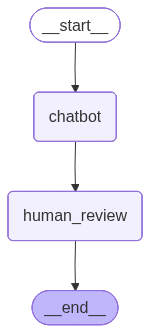

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
def chat_loop():
    thread_id = "ollama_hitl_thread"
    config = {"configurable": {"thread_id": thread_id}}

    while True:
        user_input = input("\nUser: ")
        if user_input.lower() in ("quit", "exit", "q"):
            print("Goodbye!")
            break

        events = graph.stream(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
            stream_mode="values"
        )

        for ev in events:
            if "messages" in ev:
                print("Bot (final):", ev["messages"][-1].content)

chat_loop()

Bot (final): okay
Bot (final): How can I assist you today?

[Draft from AI]: How can I assist you today?
Bot (final): i need name
Bot (final): Of course! What kind of name would you like? Do you have any preferences or themes in mind?

[Draft from AI]: Of course! What kind of name would you like? Do you have any preferences or themes in mind?
Bot (final): Of course! What kind of name would you like? Do you have any preferences or themes in mind?
Bot (final): ruhullah
Bot (final): The name "Ruhullah" is a combination of two Persian words: "روح" (rukh), meaning "spirit," and "الله" (Allah), which refers to God. So, Ruhullah can be interpreted as "Spirit of God." It's a beautiful and meaningful name with religious significance in Islamic culture.

If you're looking for other names or have any specific requirements, feel free to let me know!

[Draft from AI]: The name "Ruhullah" is a combination of two Persian words: "روح" (rukh), meaning "spirit," and "الله" (Allah), which refers to God. 